#### This notebook is analysing my Strava and Komoot gpx data from the last 5-6 years. (c) Lars Tijssen

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpxpy

import pandas as pd
import os
import sklearn

In [17]:
pd.set_option('display.max_rows', 1000)

In [ ]:
# lets load in all the gpx files
path = 'F:\\Downloads\\strava\\activities\\'

files = os.listdir(path)
files = [path + file for file in files]

gpxtracks = []
for file in files:
    gpx_file = open(file, 'r', encoding='utf-8')
    gpx = gpxpy.parse(gpx_file)
    gpxtracks.append(gpx)
    gpx_file.close()

example of one of the gpx file and what it contains

In [18]:
test = gpxtracks[0]
test.get_moving_data()

MovingData(moving_time=5604.0, stopped_time=564.0, moving_distance=38747.210453996006, stopped_distance=64.02605402208448, max_speed=11.499018267511113)

In [19]:
# lets calculate some statistics from the gpx files and convert all the data to a Pandas DataFrame
length3d = pd.Series([a.length_3d() for a in gpxtracks], name = 'length (m)')
duration = pd.Series([a.get_duration() for a in gpxtracks], name = 'duration (s)')
uphill = pd.Series([a.get_uphill_downhill().uphill for a in gpxtracks], name = 'height meters (m)')
downhill = pd.Series([a.get_uphill_downhill().downhill for a in gpxtracks], name = 'downhill height meters(m)')
max_speed = pd.Series([a.get_moving_data().max_speed for a in gpxtracks], name = 'max speed (km/h)') * 3.6

avg_speed = length3d / duration * 3.6
avg_speed.name = 'average speed (km/h)'
title = pd.Series([a.tracks[0].name for a in gpxtracks], name = 'title', dtype = str)

lets add categories for all the gpx files. I had to do all of this by hand
The categories are:
- hiking
- cycling
- running
- skitour
- skiing
- failed (mistakes made in recording)


In [20]:
sport = ['cycling','hiking','hiking','hiking','cycling','hiking','cycling','hiking','hiking','hiking','cycling','hiking','hiking','cycling','hiking','hiking',
         'cycling','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking',
         'cycling','hiking','hiking','hiking','hiking','cycling','cycling','skitour','skitour','cycling','skitour','cycling','cycling','hiking','cycling',
         'hiking','failed','hiking','failed','failed','cycling','cycling','hiking','cycling','cycling','cycling','cycling','cycling','cycling','cycling',
         'cycling','cycling','cycling','cycling','cycling','cycling','cycling','cycling','failed','cycling','cycling','cycling','cycling','hiking','hiking',
         'hiking','cycling','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking','cycling','cycling','cycling','cycling','failed',
         'cycling','cycling','cycling','hiking','hiking','hiking','hiking','cycling','cycling','cycling','cycling','cycling','failed','failed','hiking',
         'hiking','hiking','hiking','hiking','hiking','hiking','hiking','cycling','hiking','hiking','hiking','hiking','hiking','hiking','hiking','hiking',
         'hiking','hiking','hiking','hiking','hiking','hiking','cycling','hiking','cycling','hiking','hiking','run','cycling','run','run','run','cycling',
         'hiking','hiking','run','hiking','run','hiking','hiking','hiking','cycling','cycling','hiking','hiking','hiking','hiking','cycling','hiking',
         'hiking','hiking','hiking','hiking','hiking','hiking','ski','ski','ski','ski','ski','ski','ski','hiking']

sport = pd.Series(sport, name = 'sport type', dtype = str)

finally we can load everything into a DataFrame

In [21]:
df = pd.DataFrame(data = [length3d, duration, avg_speed, uphill, max_speed, sport, title]).T                                                             
df.head()

,length (m),duration (s),average speed (km/h),height meters (m),max speed (km/h),sport type,title
0,38811.2,6168,22.6525,1183.9,41.3965,cycling,Tutzing to Starnberg around Starnberger See
1,16201.4,28022,2.08141,2325.17,16.1333,hiking,Klettersteig grade D to Berchtesgadener Hochtron.
2,13962.4,19629,2.56074,611.49,10.9775,hiking,Stohrhaus - Marktschellenberg
3,14573.7,29527,1.77686,1113.73,9.41639,hiking,Wankspitze
4,62439.1,10685,21.037,1955,44.8053,cycling,Aussicht auf das Isarwehr Höllriegelskreuth


lets get rid of the data that is marked faulty

In [22]:
df = df[df['sport type'] != 'failed']

Now we can have some fun to analyze the data. Let's first see if we can discern the different sport types by their dependencies

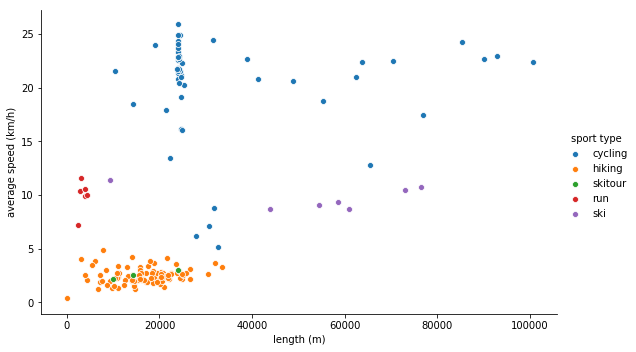

In [23]:
sns.pairplot(data = df[['length (m)','average speed (km/h)','sport type']], 
             hue = 'sport type', 
             height = 5, 
             x_vars='length (m)', 
             y_vars='average speed (km/h)', 
             aspect = 1.6)

In this graph we can really see the difference between sport types. 

First of all there are the hikes, which have a low to medium distance but a very low average speed. Then there are the runs which have a very low distance but medium average pace. The cycling tours that I did can be identified by their high average speed and medium to long length. There is a bunch of cycling tours cluttered together with almost the same distance: These are from my commuting route. The ski runs also have a long distance but lower average pace (thanks to the lifts in between). And finally there are the skitours which are indiscernable in this graph from hikes because they have more or less the same pace and length.

We could actually pick out the skitours from the hikes if we use max speed, but then the other types become more difficult to identify

Okay lets see if we can find out something about hiking.

In [24]:
df_hiking = df[df['sport type'] == 'hiking']

Let's say we want to see the distribution of the height meters (m) for all hikes

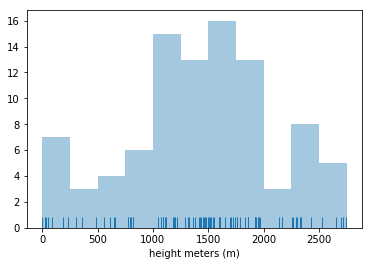

In [25]:
sns.distplot(df_hiking['height meters (m)'].astype(np.float64), bins=np.arange(0,3000,250), kde=False, rug=True);

Lets plot the height and distance profile of the hike with the most height meters

In [26]:
df_hiking[df_hiking['height meters (m)'] == df_hiking['height meters (m)'].max()]

,length (m),duration (s),average speed (km/h),height meters (m),max speed (km/h),sport type,title
170,33451.7,36200,3.32669,2746.54,10.8395,hiking,Benediktenwand Brauneck


Track number 170 is the one with the most height meters. We can select the data using the gpx data we loaded in at the beginning

In [ ]:
hike_gpx_track = gpxtracks[170]

Let's pour the information into a pandas dataframe

In [42]:
hike_gpx_data = [(i.point.latitude, i.point.longitude, i.point.elevation, i.distance_from_start) for i in hike_gpx_track.get_points_data()]

df_hike = pd.DataFrame(hike_gpx_data, columns = ['latitude','longitude','elevation','distance'])
df_hike.head()

,latitude,longitude,elevation,distance
0,47.660804,11.371230,609.0,0.000000
1,47.660780,11.371255,609.0,3.263612
2,47.660763,11.371204,609.0,7.530047
3,47.660754,11.371155,609.0,11.338021
4,47.660736,11.371101,609.0,15.855425


In [43]:
df_hike[df_hike['elevation'] < 500] 

,latitude,longitude,elevation,distance
2051,47.654264,11.418848,-0.1,9261.156660
2053,47.654291,11.418767,-0.1,11645.967138


There are some mistakes in the elevation profile. Let's get rid of them

In [45]:
df_hike['elevation'] = df_hike['elevation'][df_hike['elevation'] > 0]

Text(0,0.5,'height (m)')

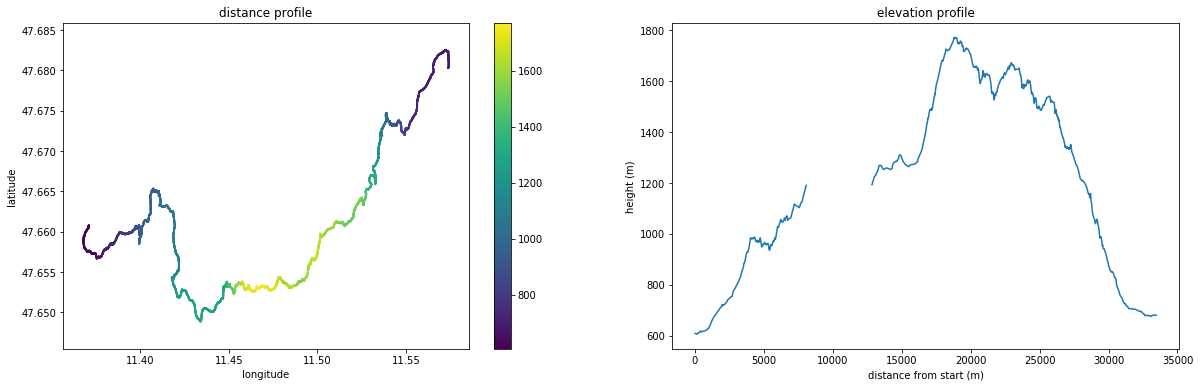

In [51]:
fig, axes = plt.subplots(figsize = (20,6), nrows = 1, ncols=2)

ax1, ax2 = axes


# ax1
ax1scat = ax1.scatter(df_hike.longitude, df_hike.latitude, c=df_hike.elevation, s = 1)
ax1.set_title('distance profile')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
plt.colorbar(ax1scat, ax=ax1)


ax2.plot(df_hike.distance, df_hike.elevation)
ax2.set_title('elevation profile')
ax2.set_xlabel('distance from start (m)')
ax2.set_ylabel('height (m)')

That's it for now. Obviously there is a lot more that you can do with this data. This is just meant as a sneak peek. Hope you enjoyed it!